vae2　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
! pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータの生成

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(len(x_train))

1797


サンプルデータの図化

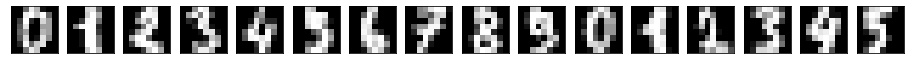

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
"""
def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum()
  return -z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum()
  return -y
"""
import torch.distributions as td

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid, momentum=0.1)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    x2 = F.relu( self.fc1(x) )
    #x1 = F.relu( self.fc1(x) )
    #x2 = self.bn1( x1 )
    self.mean    = self.fc2_mean(x2)
    self.log_var = self.fc2_var(x2)

    # reparametrization(vae1)
    #eps = torch.randn( self.mean.shape )
    #nm = td.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal( 0.0,1.0,[32,2] )
    #print("eps",eps)
    #self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )

    self.std = torch.exp( 0.5 * self.log_var )
    q_z = td.normal.Normal( self.mean, self.std )
    self.z = q_z.rsample()

    # decoder
    y = F.relu( self.fc3( self.z ) )
    #y = self.drop1( y )
    y = torch.sigmoid( self.fc4(y) )
    self.out = y
    
    # vae1
    #e1 = reconstruction( y, x )
    #e1 = F.binary_cross_entropy( y , x, reduction="sum" )
    #e2 = kl_divergence( self.mean, self.log_var )
    # vae2
    e1 = F.binary_cross_entropy( y , x, reduction="sum" )
    p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
    e2  = td.kl_divergence( q_z, p_z ).sum()
    #print("e1,e2",e1,e2)

    self.loss1 = e1
    self.loss2 = e2
    return (e1+e2)

計算グラフをJSONファイルに変換する

In [9]:
def generate_json( json_path, input ):

    model = Net( n_in, n_mid, n_out, n_z )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [10]:
torch.manual_seed( 1 )

project = 'vae2'
json_path = './network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#x.requires_grad = True

model = generate_json( json_path, x )

[SAVE] ./network/vae2.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc4]/weight/fc4
skip: Net/Linear[fc4]/weight/fc4


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::normal(%63, %71, %72) # /usr/local/lib/python3.7/dist-packages/torch/distributions/utils.py:47:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.4703369140625 (up to 1e-05 allowed)
Relative difference: 0.0003294008981624594 (up to 1e-05 allowed)
  _module_class,


一回の順伝播、逆伝播のC++コードを生成する

In [11]:
folder = "./vae"
CV.convert_cpp_code( project, folder, model, x, json_path )

[JSON] ./network/vae2.json
{'name': 'Net/Linear[fc1]/weight/weight.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/bias.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/weight.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/bias.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/weight.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [10], 'sorted_id': 8}
{'name': 'Net/Linear[fc2_var]/bias/bias.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [10], 'sorted_id': 9}
{'name': 'Net/Linear[fc3]/weight/weight.17', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [47], 'sorted_id': 45}
{'name': 'Net/Line

In [12]:
# check code
#x.requires_grad = True
with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  output.backward()
  #print("output",output.grad)
  print("loss1",model.loss1)
  print("loss2",model.loss2)
  #print("input_grad",x.grad)

output tensor(1428.4191, grad_fn=<AddBackward0>)
loss1 tensor(1427.9717, grad_fn=<BinaryCrossEntropyBackward0>)
loss2 tensor(0.4474, grad_fn=<SumBackward0>)


C++コードをコンパイル、リンクする

In [13]:
!g++ -std=c++14 ./vae/vae2.cpp ./vae/vae2_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./vae/vae2

(注) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [25]:
!./vae/vae2

### forward computation ...
{ 1428.170898}
### backward computation ...
input_grad{{ 0.124433, -0.056509, -0.082816, ..., -0.0127  , -0.068528, -0.069184},
 {-0.00068 ,  0.005626, -0.005974, ...,  0.006481,  0.008314, -0.000812},
 { 0.87027 , -0.475182, -0.492841, ..., -0.000243, -0.286684, -0.528184},
 ..., 
 { 0.010591, -0.03078 , -0.02364 , ..., -0.004601, -0.024262,  0.03356 },
 { 0.508923, -0.228583, -0.263411, ..., -0.0179  , -0.162171,  0.004871},
 { 0.580696, -0.255019, -0.292091, ..., -0.040616, -0.170888,  0.048526}}


*学習ループの実行(python)*

In [ ]:
torch.manual_seed( 1 )

project = 'vae2'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#x.requires_grad = True

net = Net( n_in, n_mid, n_out, n_z )
net.train()

lr  = 0.001
opt = torch.optim.SGD(net.parameters(), lr)

epoch_loss = []
epoch_num = 200; 
for epoch in range(epoch_num):

  loss = net( x )
  print("loss",loss)

  opt.zero_grad()
  loss.backward()
  #print("output",output.grad)

  opt.step()
  print("EPOCH: {} loss: {}".format(epoch, loss))
  epoch_loss.append( loss )

ミニバッチのよる学習ループの実行 (python版)

In [27]:
torch.manual_seed( 1 )

epoch_num = 200
batch_size = 32

e = torch.randn( batch_size, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z )
net.train()

lr = 0.001
opt = torch.optim.SGD(net.parameters(), lr)
#opt = torch.optim.Adam(net.parameters(), lr )

epoch_loss = []

n_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

for i in range(epoch_num):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        
        # 順伝播と逆伝播
        loss = net( x_mb )
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        opt.step()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )

    net.eval()
    loss = net( x2 )
    print("loss ",loss,net.loss1,net.loss2)
    epoch_loss.append( loss )

batch 56 1797 32
EPOCH: 0 loss: 59497.28515625
loss  tensor(52225.1719, grad_fn=<AddBackward0>) tensor(49180.4062, grad_fn=<BinaryCrossEntropyBackward0>) tensor(3044.7659, grad_fn=<SumBackward0>)
EPOCH: 1 loss: 51131.26171875
loss  tensor(50800.4453, grad_fn=<AddBackward0>) tensor(48757.7578, grad_fn=<BinaryCrossEntropyBackward0>) tensor(2042.6881, grad_fn=<SumBackward0>)
EPOCH: 2 loss: 50365.08203125
loss  tensor(50085.1484, grad_fn=<AddBackward0>) tensor(48867.8359, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1217.3142, grad_fn=<SumBackward0>)
EPOCH: 3 loss: 49813.85546875
loss  tensor(49592.3438, grad_fn=<AddBackward0>) tensor(48560.8867, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1031.4556, grad_fn=<SumBackward0>)
EPOCH: 4 loss: 49056.08984375
loss  tensor(48775.1484, grad_fn=<AddBackward0>) tensor(47380.2891, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1394.8586, grad_fn=<SumBackward0>)
EPOCH: 5 loss: 48238.19140625
loss  tensor(47937.2461, grad_fn=<AddBackward0>) tensor(46

収束状況グラフを描画する

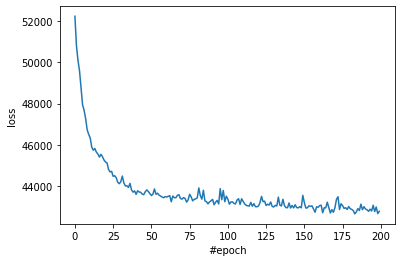

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

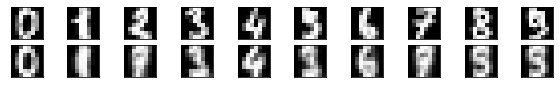

In [29]:
n_img2=10
x2=x[:n_img2]

o = net.out.to('cpu').detach().numpy().copy()

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

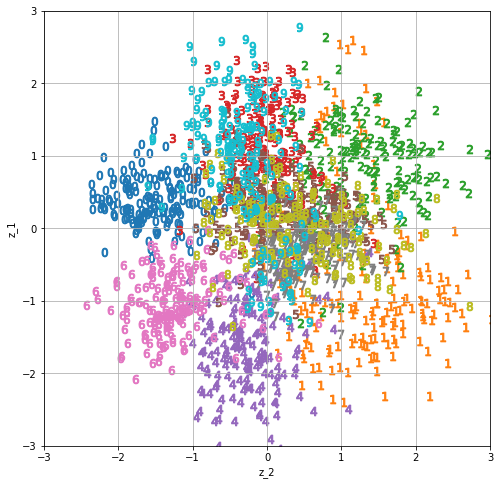

In [30]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

潜在変数を変化させたときの画像を描画する

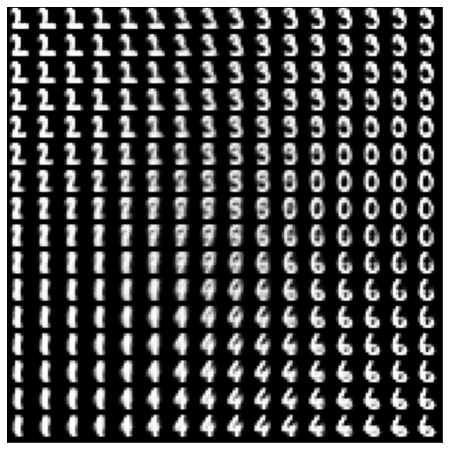

In [31]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

ミニバッチ用の学習用データファイル、学習ループのC++コードを生成する

In [32]:
CV.convert_data_file( project, folder, inp_data=dd )
CV.convert_train_code( project, folder, json_path, sol="vae", z="fc3", epochs=200, batch=32, lr=0.001, inp_data=dd )

datafile key :  inp_data
param: inp_data  - str loop  5000  /  14375
param: inp_data  - str loop  10000  /  14375
[DATA] ./vae/vae2_data.cpp
[JSON] ./network/vae2.json
epoch_num :  200
batch_size :  32
lr :  0.001
inp shape (1797, 64) 2
inp  shape :  1 {1797,64}
pred shape :  0 
target shape :  0 
div :  False
nb,nk :  55 91
batch_size: 32
inp_shape: {1797,64}
bce_no :  55
unpack0 aten::sigmoid
unpack original no:  52 52
vae z:  44  keyw: fc3
[TRAIN]  ./vae/vae2_train.cpp


学習用のC++コードをコンパイル、リンクする

In [33]:
!g++ -std=c++14 ./vae/vae2.cpp ./vae/vae2_param.cpp ./vae/vae1_data.cpp ./vae/vae2_train.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./vae/vae2_train

(注) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [34]:
!./vae/vae2_train

epoch_num : 200
indata shape   : 1797,64
batch  number  : 56,32
learning ratio : 0.001
total_loss : epoch 0 - loss 61127.8
epoch 0 - loss 52096.6 ( 50228 , 1868.59 ) 
total_loss : epoch 1 - loss 50894.1
epoch 1 - loss 50293.8 ( 48746.5 , 1547.34 ) 
total_loss : epoch 2 - loss 49657.7
epoch 2 - loss 48926 ( 47454.7 , 1471.27 ) 
total_loss : epoch 3 - loss 48427
epoch 3 - loss 48167.3 ( 46439.7 , 1727.67 ) 
total_loss : epoch 4 - loss 47947.2
epoch 4 - loss 47643.1 ( 45703.9 , 1939.14 ) 
total_loss : epoch 5 - loss 47300.8
epoch 5 - loss 47286.5 ( 45504 , 1782.44 ) 
total_loss : epoch 6 - loss 46697.7
epoch 6 - loss 46568.9 ( 44521.7 , 2047.16 ) 
total_loss : epoch 7 - loss 46278.6
epoch 7 - loss 46257.9 ( 44106.9 , 2151.06 ) 
total_loss : epoch 8 - loss 46047.9
epoch 8 - loss 46551 ( 44071.1 , 2479.83 ) 
total_loss : epoch 9 - loss 45878.2
epoch 9 - loss 45960.5 ( 43591.6 , 2368.95 ) 
total_loss : epoch 10 - loss 45802.8
epoch 10 - loss 45763.8 ( 43311.1 , 2452.76 ) 
total_loss : epoch 

c++ からの出力ファイルの読み込み

In [35]:
# load out file
f = open('./vae/vae2.out', 'r')
epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('./vae/vae2.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

# load z file
f3 = open('./vae/vae2.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[52096.628906, 50293.800781, 48926.0, 48167.320312, 47643.070312, 47286.460938, 46568.851562, 46257.933594, 46550.972656, 45960.496094, 45763.84375, 45642.210938, 46027.621094, 45502.449219, 45398.105469, 45387.355469, 45300.082031, 45620.46875, 45252.46875, 45000.847656, 45180.621094, 45029.125, 44624.5625, 44513.722656, 44908.105469, 44418.578125, 44554.898438, 44378.265625, 44275.480469, 44033.261719, 44145.621094, 44112.710938, 44061.828125, 44099.640625, 44577.632812, 44101.382812, 44221.839844, 43767.691406, 44242.488281, 43752.640625, 43760.34375, 43789.214844, 43943.367188, 43841.695312, 43655.140625, 43903.972656, 43592.414062, 43756.054688, 43590.121094, 43696.414062, 43672.496094, 43662.691406, 43551.753906, 43458.605469, 43536.128906, 43781.632812, 43574.699219, 43644.433594, 43442.59375, 43439.160156, 43524.109375, 43603.066406, 43480.777344, 43884.542969, 43633.410156, 43414.378906, 43336.046875, 43384.847656, 43301.183594, 43401.160156, 43271.199219, 43381.19

収束状況グラフを描画する

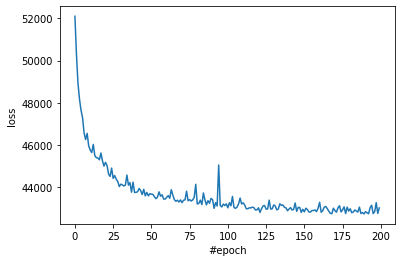

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

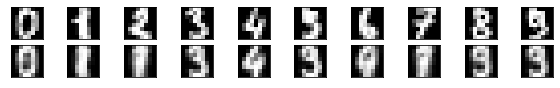

In [37]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

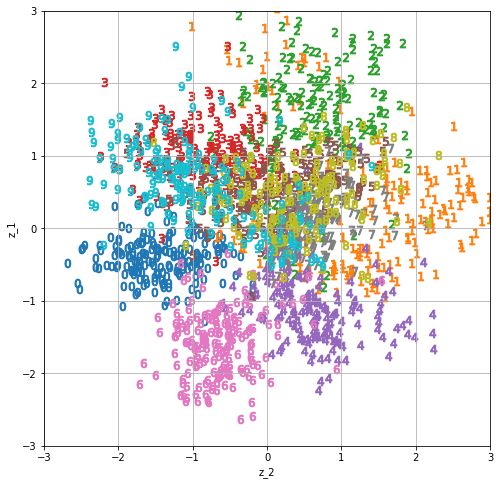

In [38]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()